# Predicting Forest Fires with Machine Learning
## 1. Introduction
With the threat of climate change seemingly forever worsening, forest fires are having an increasingly negative effect around the world. Wildlife are in the front line of this danger, with ecosystems being destroyed and animal populations reducing towards extinction. In addition, a growing human population in rural areas is putting more lifes at risk as well. This project, using environmental conditions as variables, will attempt to predict when fires will occur. Therefore, in the future, by analysing weather forcasts, the impact of future fires will hopefully be minimised.

This investigation will be using a dataset of Algerian Forest Fires as an example. This dataset includes environmental conditions of 2 regions (Bejaia & Sidi Bel Addis) which are threatened by fires between June-September 2012. It was taken from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++). The column headings are as follows:

- Day
- Month
- Year
- Temp - Max temperature in Celsius.
- RH - Relative Humidity in %.
- Ws - Wind speed in km/h.
- Rain - Total rain in day in mm.
- FFMC - Fine Fuel Moisture Code, moisture content of litter and other cured fine fuels, indicates ease of ignition and flammability of fine fuel.
- DMC - Duff Moisture Code, avg moisture content of loosely compacted organic layers of moderate depth.
- DC - Drought Code, avg moisture content of deep, compact organic layers, indicates seasonal drought effects.
- ISI - Initial Spread Index, expected rate of fire spread.
- BUI - Buildup Index, total amount of fuel available for combustion.
- FWI - Fire Weather Index, rating of fire intensity.
- Classes - whether there was 'fire' or 'not fire' that day.

Due to the availability of the 'Classes' column, I will use supervised machine learning classification methods in this project.

## 2. Inspecting & Tidying Data
Firstly, the appropriate python libraries and the dataset were imported into Jupyter Noteboook.

As all the data was collected in the same year (2012), the year column was dropped.

In [146]:
#Import Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score, train_test_split, KFold
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#Read csv file into Jupyter Notebook
fires = pd.read_csv('Algerian_forest_fires.csv')

#Drop year column and rename some column headings
fires = fires.drop(columns=['year'])
fires = fires.set_axis(['day','month','temp','RH','WS','rain','FFMC','DMC','DC',
                        'ISI','BUI','FWI', 'region', 'classes'], axis=1, inplace=False)

display(fires.head())

,day,month,temp,RH,WS,rain,FFMC,DMC,DC,ISI,BUI,FWI,region,classes
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,Bejaia,not fire
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,Bejaia,not fire
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,Bejaia,not fire
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,Bejaia,not fire
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,Bejaia,not fire


In [147]:
display(fires.describe())

display(fires.dtypes)

,day,month,temp,RH,WS,rain,FFMC,DMC,DC,ISI,BUI,FWI
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,15.754098,7.500000,32.172131,61.938525,15.504098,0.760656,77.887705,14.673361,49.288115,4.759836,16.673361,7.049180
std,8.825059,1.112961,3.633843,14.884200,2.810178,1.999406,14.337571,12.368039,47.619662,4.154628,14.201648,7.428366
min,1.000000,6.000000,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,8.000000,7.000000,30.000000,52.000000,14.000000,0.000000,72.075000,5.800000,13.275000,1.400000,6.000000,0.700000
50%,16.000000,7.500000,32.000000,63.000000,15.000000,0.000000,83.500000,11.300000,33.100000,3.500000,12.450000,4.450000
75%,23.000000,8.000000,35.000000,73.250000,17.000000,0.500000,88.300000,20.750000,68.150000,7.300000,22.525000,11.375000
max,31.000000,9.000000,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000


day          int64
month        int64
temp         int64
RH           int64
WS           int64
rain       float64
FFMC       float64
DMC        float64
DC         float64
ISI        float64
BUI        float64
FWI        float64
region      object
classes     object
dtype: object

Inital inspections of that data seem to suggest that it is tidy:
* All variables have 244 entries.
* The days of the month range from 1 to 31, and the months range from 6 to 9 (Jun-Sept)
* The environmental conditions are reasonable, for example temp ranges from 22-42 Celcius and all RH values are between 0-100%
* All datatypes are in the correct form

The data will have to be standardized later before creating a ML model as the ranges of the variables differ greatly.

However, after inspecting the data further, I discovered that there were 8 unique strings for 'classes'. This was due to excess whitespace in the strings which was subsequently stripped, leaving correctly only 2 classes. 

In [148]:
#Print all unique values of the classes column
print('Unique classes values before tidying')
print(fires.classes.unique())

#Strip whitespace from classes column
fires['classes'] = fires.classes.str.strip()

#Print all unique values of newly formated column
print('')
print('Unique classes values after tidying')
print(fires.classes.unique())

Unique classes values before tidying
['not fire   ' 'fire   ' 'fire' 'fire ' 'not fire' 'not fire '
 'not fire     ' 'not fire    ']

Unique classes values after tidying
['not fire' 'fire']


Next, I decided to investigate whether the month was a significant variable in predicting whether or not a fire would occur. If not, this column could be dropped from the modelling.

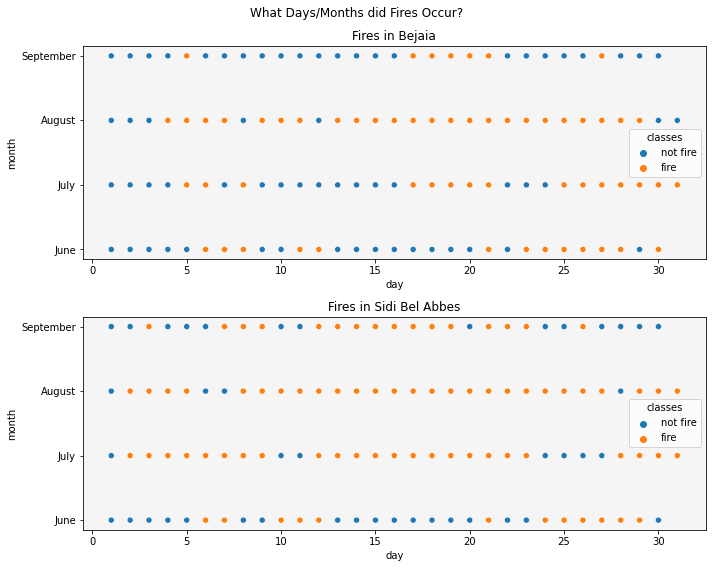

Days of Fires (Bejaia):
June: 13
July: 15
August: 24
September: 7
TOTAL: 59

Days of Fires (Sidi Bel Abbes):
June: 12
July: 24
August: 27
September: 16
TOTAL: 79


<Figure size 432x288 with 0 Axes>

In [149]:
#Split datasets into 2 by region
beja = fires[fires.region == 'Bejaia']
sidi = fires[fires.region == 'Sidi-Bel Abbes']

month_names = ['June', 'July', 'August', 'September']

#Create a 2x1 subplot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=True)
fig.suptitle('What Days/Months did Fires Occur?')

#Plot scatter of day vs month with classes as hue for both regions
sns.scatterplot(ax=axes[0], x=beja.day, y=beja.month, hue=beja.classes)
axes[0].set_title('Fires in Bejaia')
sns.scatterplot(ax=axes[1], x=sidi.day, y=sidi.month, hue=sidi.classes)

#Format graph
axes[1].set_title('Fires in Sidi Bel Abbes')
axes[0].set_yticks(range(6,10,1))
axes[0].set_yticklabels(month_names)
plt.tight_layout()
axes[0].set_facecolor('whitesmoke')
axes[1].set_facecolor('whitesmoke')
plt.show()
plt.clf()

#Print number of days per month where a fire occurred for both regions
print('Days of Fires (Bejaia):')
print(f"June: {len(beja[(beja.month == 6) & (beja.classes == 'fire')])}")
print(f"July: {len(beja[(beja.month == 7) & (beja.classes == 'fire')])}")
print(f"August: {len(beja[(beja.month == 8) & (beja.classes == 'fire')])}")
print(f"September: {len(beja[(beja.month == 9) & (beja.classes == 'fire')])}")
print(f"TOTAL: {len(beja[(beja.classes == 'fire')])}")
print('')
print('Days of Fires (Sidi Bel Abbes):')
print(f"June: {len(sidi[(sidi.month == 6) & (sidi.classes == 'fire')])}")
print(f"July: {len(sidi[(sidi.month == 7) & (sidi.classes == 'fire')])}")
print(f"August: {len(sidi[(sidi.month == 8) & (sidi.classes == 'fire')])}")
print(f"September: {len(sidi[(sidi.month == 9) & (sidi.classes == 'fire')])}")
print(f"TOTAL: {len(sidi[(sidi.classes == 'fire')])}")

As indicated by the findings, the month does play a significant role. For example, in Bejaia, we can see that there were fires on a staggering 24 out of 31 days in August, compared to only 7 out of 30 in September

In both regions, August had the most days of fire, whereas September and June had the least in Bejaia and Sidi Bel Addes respectively.

The data also tells us that fires are a greater threat in Sidi Bel Abbes with a total of 79 in 122 days.

Therefore, the months were binned using One Hot Encoding and converted into a binary variable to be used in the modelling later.

In [150]:
#Create bins for each month
bins = [6, 7, 8, 9, 10]
months = fires['month']
fires['month_name'] = pd.cut(months, bins, right = False)

#One Hot Encode months to a binary variable
ohe = pd.get_dummies(fires['month_name'])
 
fires = fires.join(ohe)

Lastly, the 'classes' column was also converted to a binary variable, where 1 and 0 corresponds to 'fire' and 'not fire' respectively.

Now all the data except for 'region' is in numerical form, ready to be used in the machine learning models.

In [151]:
#Replaces 'not fire' and 'fire' with 0 and 1 (integers) respectively in classes column
fire_lst = []
classes = fires['classes'].tolist()
for item in classes:
    if item == 'not fire':
        fire_lst.append(0)
    else:
        fire_lst.append(1)

fires['classes'] = fire_lst
fires['classes'] = fires.classes.astype(int)

The irrelevent columns were dropped and column names and order were changed, leaving the final dataset which can be viewed below.

In [152]:
#Drop unneeded columns
fires = fires.drop(columns=['month_name', 'day','month'])

#Set new column names
fires = fires.set_axis(['temp','RH','WS','rain','FFMC','DMC','DC','ISI','BUI','FWI',
                        'region', 'classes', 'is_jun', 'is_jul', 'is_aug', 'is_sept'], axis=1, inplace=False)

#Rearrange column order so output variable (classes) is last
fires = fires[['temp','RH','WS','rain','FFMC','DMC','DC','ISI','BUI','FWI',
                'region', 'is_jun', 'is_jul', 'is_aug', 'is_sept', 'classes']]

display(fires.head())

,temp,RH,WS,rain,FFMC,DMC,DC,ISI,BUI,FWI,region,is_jun,is_jul,is_aug,is_sept,classes
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,Bejaia,1,0,0,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,Bejaia,1,0,0,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,Bejaia,1,0,0,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,Bejaia,1,0,0,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,Bejaia,1,0,0,0,0


In [153]:
print(fires.dtypes)

temp         int64
RH           int64
WS           int64
rain       float64
FFMC       float64
DMC        float64
DC         float64
ISI        float64
BUI        float64
FWI        float64
region      object
is_jun       uint8
is_jul       uint8
is_aug       uint8
is_sept      uint8
classes      int32
dtype: object


## 3. Standardizing Data

To perform certain ML model accurately, data must be standardize so that all variables have the same scale. Otherwise, variables with large scales/ranges will naturally have a greater influence on the model.

I decided to use z-score standardization. A method which subtracts the mean and divides by the standard deviation, leaving the mean and std of all variables to be 1 and 0 respectively. This was applied to all columns except 'region' and 'classes'. This was achieved using the StandardScaler() function from the sklearn library.



In [154]:
#Standardizes all columns except classes and region using StandardScaler()
fires[['temp','RH','WS','rain','FFMC','DMC','DC','ISI','BUI','FWI', 'is_jun', 'is_jul', 'is_aug', 'is_sept']]= StandardScaler().fit_transform(fires[[
    'temp','RH','WS','rain','FFMC','DMC','DC','ISI','BUI','FWI', 'is_jun', 'is_jul', 'is_aug', 'is_sept']])

display(fires.head())

,temp,RH,WS,rain,FFMC,DMC,DC,ISI,BUI,FWI,region,is_jun,is_jul,is_aug,is_sept,classes
0,-0.874735,-0.332478,0.889990,-0.381223,-0.851801,-0.913365,-0.877239,-0.834479,-0.936556,-0.883457,Bejaia,1.75119,-0.58366,-0.58366,-0.57104,0
1,-0.874735,-0.063185,-0.892913,0.270307,-0.942658,-0.856651,-0.877239,-0.906836,-0.901277,-0.896947,Bejaia,1.75119,-0.58366,-0.58366,-0.57104,0
2,-1.702005,1.350607,2.316313,6.184192,-2.151758,-0.986283,-0.887760,-1.075669,-0.985948,-0.937415,Bejaia,1.75119,-0.58366,-0.58366,-0.57104,0
3,-1.977761,1.821872,-0.892913,0.871719,-3.444727,-1.083506,-0.891969,-1.148026,-1.056507,-0.950905,Bejaia,1.75119,-0.58366,-0.58366,-0.57104,0
4,-1.426248,1.013990,0.176829,-0.381223,-0.914702,-0.945773,-0.738355,-0.858598,-0.901277,-0.883457,Bejaia,1.75119,-0.58366,-0.58366,-0.57104,0


## 4. Visualizing Trends Between Variable

Before creating a ML model, it is useful to analyse trends between variables. The 'classes' column was set as the hue parameter in the hope that it might become apparent which factors contribute most to the possibility of a fire.

Firstly, the weather conditions were compared to each other.

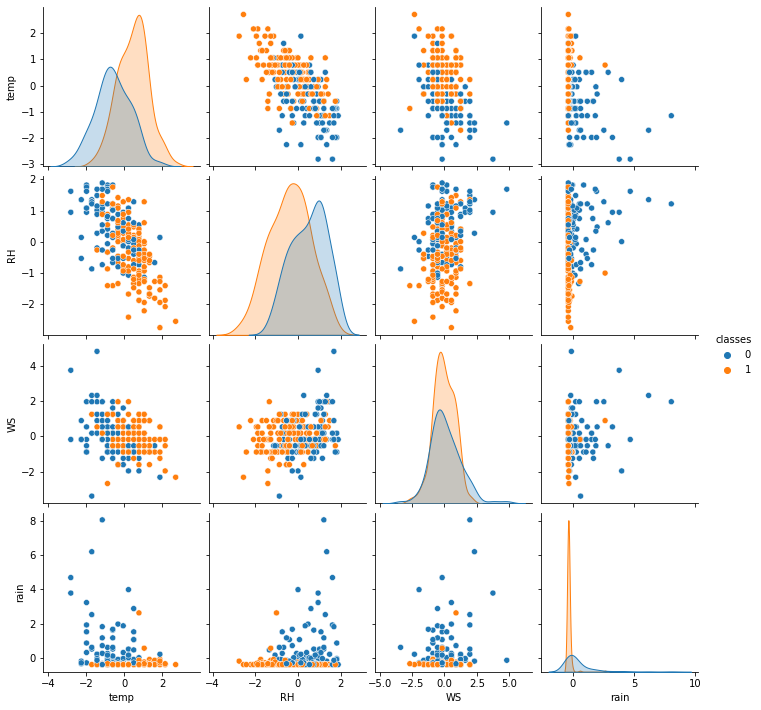

<Figure size 432x288 with 0 Axes>

In [155]:
#Pairplot of weather condition variables only
pairplot_df = fires.drop(columns = ['region', 'is_jun', 'is_jul', 'is_aug', 'is_sept','FFMC','DMC','DC','ISI','BUI','FWI'])
sns.pairplot(pairplot_df, hue='classes')
plt.show()
plt.clf()

This pairplot indicates a pretty strong correlation between the dependent and independent variables. It confirms some expected trends such as:
* Fires usually occur at higher temperatures. Also, at lower temps, there is normally more rainfall and a greater humidity.
* Fires are less likely to occur at higher humidities, this could be due to the afore mentioned relationship between humidity and temperature.
* Wind speed does not seem to make a large contribution to fires, except when both temperatures and wind speed are high.
* The majority of forest fires occur when there has been very little to no rainfall that day.

Next, the Fire Weather Index variables were compared.

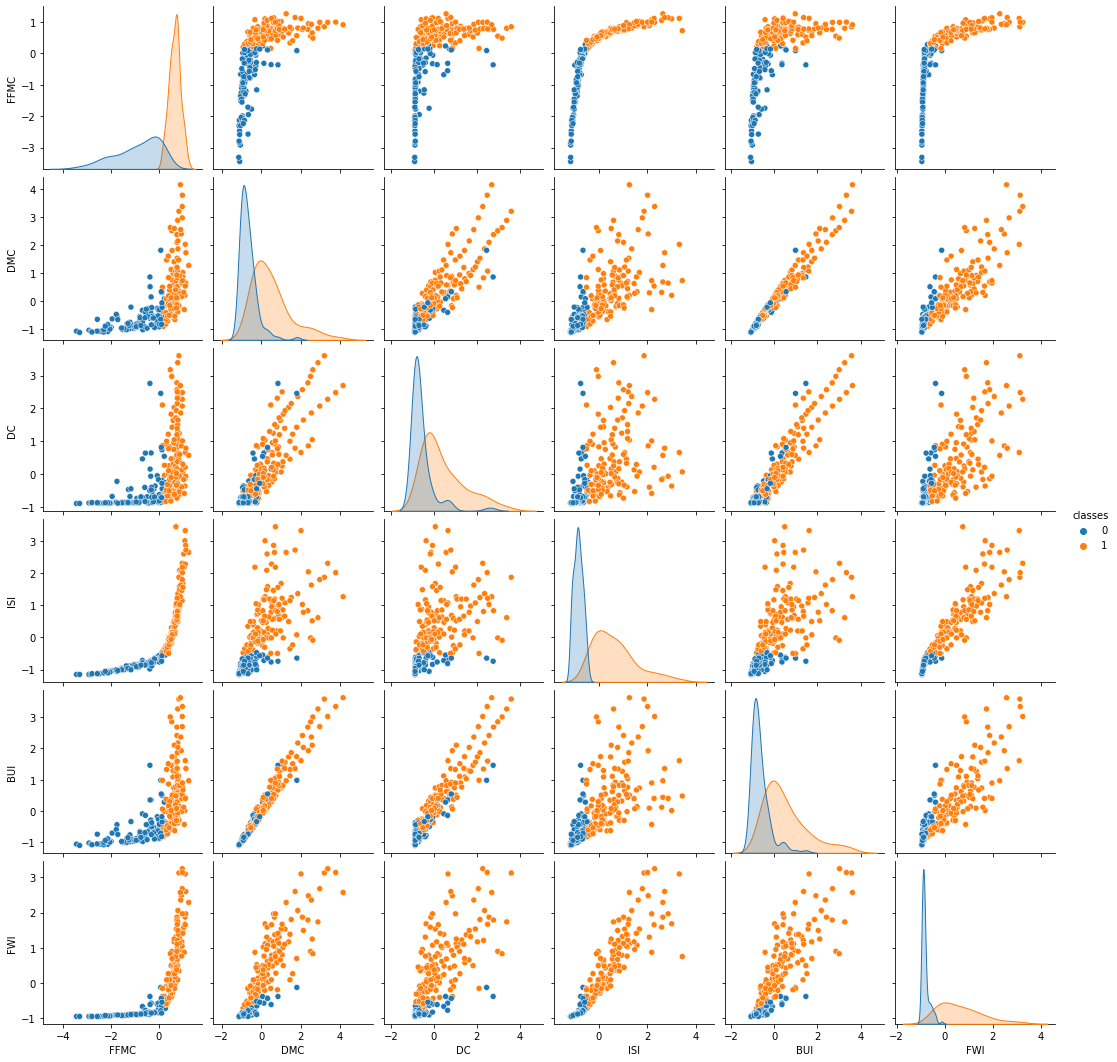

<Figure size 432x288 with 0 Axes>

In [156]:
#Pairplot of Fire Warning Index variables only
pairplot2_df = fires.drop(columns = ['region', 'is_jun', 'is_jul', 'is_aug', 'is_sept','temp','RH','WS','rain'])
sns.pairplot(pairplot2_df, hue='classes')
plt.show()
plt.clf()

There are very strong correlations between varibles in this pairplot, with 2 distinct clusters observed for every relationship. It can also be noted that all variables have a positive correlation to the possibility of a fire.

## 5. Constructing Supervised ML Models
As each region has differing conditions, and the Sidi Bel Abbes region is at a higher risk to fires than the Bejaia region, I decided to create a model for both regions so that each model could more accurately predict forest fire risk.

### Bejaia
The correlation between variables was checked using a heatmap. This is an important step for two reasons. Firstly, it will help identify which variables will have a greater contribution to our model. Secondly, it can determine if variables are correlated strongly with each other and therefore violating the multicolinearity assumption for modelling. If this does occur, then that particular data may need to be excluded from our models.

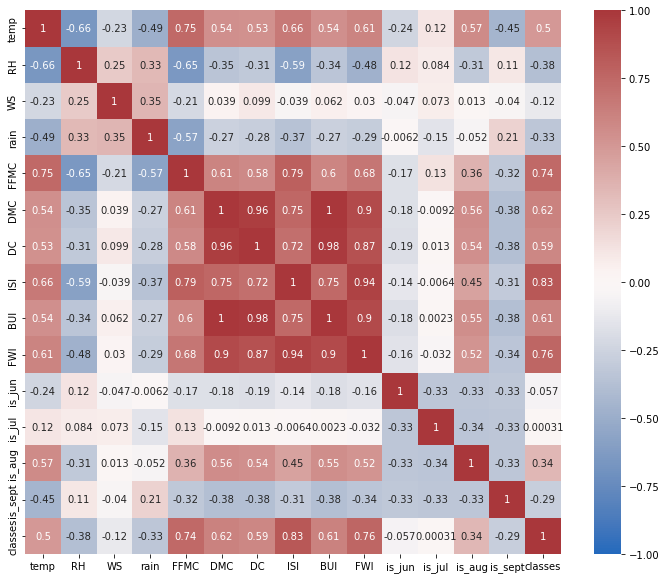

In [157]:
#Filters dataset to only Bejaia region and drops region column
beja = fires[fires.region == 'Bejaia']
beja = beja.drop(columns='region')

# Correlation Grid of variables
corr_grid = beja.corr()

#Plots correlation in a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_grid, vmin=-1, vmax=1, center=0,  cmap='vlag', annot=True)
plt.show()

* Many variables contribute strongly to 'classes', for example ISI and FFMC have a correlation of 0.83 and 0.74 respectively.
* Unfortunately, many columns also correlate strongly with each other and can not all be used in the modelling.

Therefore, I decided to keep the column which had the strongest relationship with 'classes', in this case ISI. Then I removed all variables which had a correlation of 0.7 or stronger with ISI.

In [158]:
beja = beja.drop(columns=['BUI', 'FFMC', 'FWI', 'DMC', 'DC'])

#### Method Testing

The next step is to determine which classification method to use.

As this is a supervised learning classification problem, I considered 5 methods:
* Logistic Regression
* Support Vector Machines
* Decision Trees
* K Nearest Neighbors
* Random Forests

The data from the Bejaia region was split into train and test sets. Then each method was trained and tested, with their accuracy and standard deviation measured.

As the Bejaia dataset consists of only 122 entries, a K fold cross validation method was used.

In [159]:
#Seperates input and outcome variables
#X is all variables except 'classes'
#y is only 'classes' column
X = beja.iloc[:,:-1]
y = beja.iloc[:,-1]

#Splits data into train and test sets at ratio of 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 6)

# List of model names and model code
models = []

models.append(('LR', LogisticRegression()))   
models.append(('SVC', SVC()))              
models.append(('Trees', DecisionTreeClassifier()))              
models.append(('KNN', KNeighborsClassifier()))              
models.append(('Random forest', RandomForestClassifier()))        


names = []
results = []
std = []

#Loops through each model in models list
for name, model in models:
    
    #Fits model with training data
    temp_model = model.fit(X_train, y_train)
    
    #Uses 10 folded validation to test model and record results
    kfold = KFold(n_splits = 10, random_state = 6, shuffle = True)
    cv_results = cross_val_score(temp_model, X_test, y_test, cv = kfold, scoring = 'accuracy')
    
    #Add name, mean score and std to relevent list for printing and plotting
    names.append(name)
    results.append(cv_results.mean())
    std.append((cv_results.std())/2)
    
    print(f'{name}: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

LR: Accuracy of 92.0% (std: 0.1291)
SVC: Accuracy of 84.0% (std: 0.1726)
Trees: Accuracy of 94.0% (std: 0.1181)
KNN: Accuracy of 78.0% (std: 0.1944)
Random forest: Accuracy of 94.0% (std: 0.1181)


The results of the method test can be viewed more easily in the bar chart below, with the error bars portraying the standard deviation.

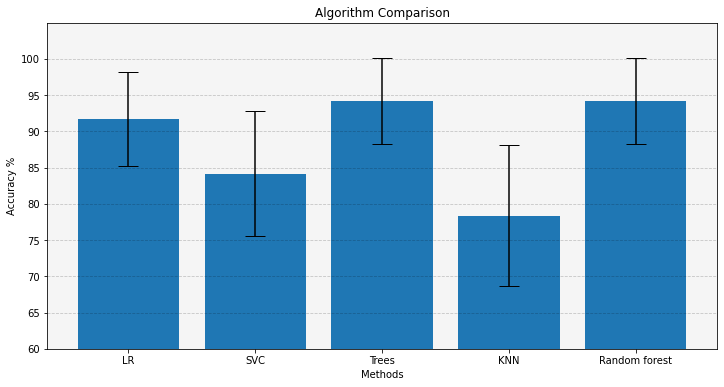

<Figure size 432x288 with 0 Axes>

In [160]:
#Plots name vs mean score, with std as error bars
plt.figure(figsize = (12,6))
ax = plt.subplot()

plt.bar(names, height=results, yerr=std, capsize=10)

plt.title('Algorithm Comparison')
plt.xlabel('Methods')
plt.ylabel('Accuracy %')

ax.set_xticks(range(5))
ax.set_xticklabels(names)
ax.set_ylim(0.6,1.05)
ax.set_yticks(np.arange(0.6,1.01,0.05))
ax.set_yticklabels(np.arange(60,101,5))

ax.grid(zorder=0, linestyle='dashed', axis='y', alpha=0.2, color='black')
ax.set_facecolor('whitesmoke')

plt.show()
plt.clf()

Logistsic Regression, Decision Trees and Random Forest all scored over 90% in the inital accuracy readings. This is a fantastic start as the model will later be fine tuned so accuracy is expected to improve.

Although Random Forest achieved the greatest score, Logistic Regression has a built in option to use Regularization. As our variables are highly correlated and there is only a 5% difference at the moment, I decided to create my model using a Logistic Regression model.

#### Feature Selection

The model currently includes 9 feature variables which it is using to predict outcomes. Using feature selection it is possible to reduce the number of variables which improves model efficiency and also may improve model accuracy.

In order to do this, I deployed Sequential Feature Selection (SFS) in both the forward and backwards directions with the 'floating' argument set to 'True'.

The aim of SFS is to determine the lowest number of features we can use on the model while keeping accuracy high.

C:\Users\samga\Coding_Programs\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\samga\Coding_Programs\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


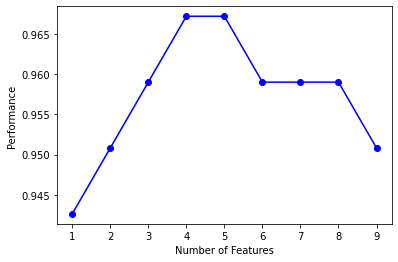

Top 4 Features: ('rain', 'ISI', 'is_jun', 'is_sept')
Average Score: 0.9672


In [161]:
#Creates LR model
lr = LogisticRegression(solver='liblinear', max_iter=1000)

#Sequential forward floating selection to find optimal number of features
sffs = SFS(lr,
          k_features=9,
          forward=True,
          floating=True,
           scoring='accuracy',
          cv=0)

sffs.fit(X,y)

#plots SFFS results
plot_sfs(sffs.get_metric_dict())
plt.show()

print(f"Top 4 Features: {sffs.subsets_[4]['feature_names']}")
print(f"Average Score: {round(sffs.subsets_[4]['avg_score'], 4)}")

The results of the forward SFS state that it is possible to reduce the number of features to 4 and still maintain a model accuracy of 96.72% which is already an improvement on our inital model.

The top 4 variables are **'rain'**, **'ISI'**, **'is_jun'** and **'is_sept'**.

C:\Users\samga\Coding_Programs\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\samga\Coding_Programs\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


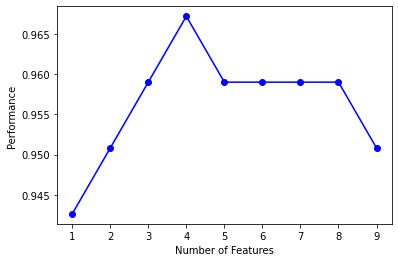

Top 4 Features: ('rain', 'ISI', 'is_jun', 'is_sept')
Average Score: 0.9672


In [162]:
#Sequential backwards floating selection to find optimal number of features
sbfs = SFS(lr,
          k_features=1,
          forward=False,
          floating=True,
          scoring='accuracy',
          cv=0)

sbfs.fit(X,y)

#Plots results on graph
plot_sfs(sbfs.get_metric_dict())
plt.show()

print(f"Top 4 Features: {sbfs.subsets_[4]['feature_names']}")
print(f"Average Score: {round(sbfs.subsets_[4]['avg_score'], 4)}")

The results of the backwards SFS confirm that a selection of 4 features produces the optimal accuracy of 96.72%.

Again these features are **'rain'**, **'ISI'**, **'is_jun'**, **'is_sept'** and they will be used for the final model.

#### Hyperparameter Tuning

Before finalising our model, the hyperparameters need to be adjusted in order to find the optimal conditions for the model to run. With Logistic Regression, the hyperparameters I will be tuning are 'C' and 'penalty', the latter refers to the method of regularization used.

Every combination of hyperparamter is tested and the best partnership and the corresponding score is found.

In [163]:
#New input variable (beja_X) defined after feature selection
beja_X = beja[['rain', 'ISI', 'is_jun', 'is_sept']]
beja_y = beja['classes']

#New train-test split with new input variables
X_train, X_test, y_train, y_test = train_test_split(beja_X, beja_y, train_size = 0.7, random_state = 6)

# Set hyperparameter ranges
C = np.logspace(-1,3,100)
lr_params = {'penalty': ['l1', 'l2'], 'C': C}

lr = LogisticRegression(solver='liblinear', max_iter=1000)

# Create a GridSearchCV model which trains the model 'lr' with each possible combination of hyperparameters in 'lr_params'
lr_grid = GridSearchCV(lr, param_grid=lr_params)
lr_grid.fit(X_train, y_train)

print(f"Best Hyperparameters: {lr_grid.best_params_}")
print(f"Best Mean Score: {round(max(lr_grid.cv_results_['mean_test_score']),4)}")

Best Hyperparameters: {'C': 0.9326033468832199, 'penalty': 'l1'}
Best Mean Score: 0.9529


The optimal hyperparameter values were found to be 'C'= 0.9326033468832199 and 'penalty'= 'l1'. The final model will be tuned using these parameter values.

#### Final Model Validation

Now that we have found the optimal conditions for our model, the model is fit with our training data and then used to predict the classification of our test data. The predictions are then compared to the actual classification to validate the effectiveness of our model.

Firstly, the mean squared error of our training and testing data is deduced. If the error of our testing data is vastly greater than our training data then our model is probably overfitting and further feature selection and regularization may be appropriate.

In [164]:
#Final LR model with optimal hyperparameters
modelB = LogisticRegression(C=0.9326033468832199, max_iter=1000, penalty='l1', solver='liblinear')

modelB.fit(X_train, y_train)

#Predict outcome classifications using train and test inputs and compare to actual outcomes to calculate MSE
#1. Training Error
pred_train = modelB.predict(X_train)
MSE_train = np.mean((pred_train - y_train)**2)
print("Training Error: ", MSE_train)

# 2. Testing Error
pred_test = modelB.predict(X_test)
MSE_test = np.mean((pred_test - y_test)**2)
print("Testing Error: ", MSE_test)

Training Error:  0.047058823529411764
Testing Error:  0.05405405405405406


Fortunately, both errors are small and similar meaning the model is not overfitting.

Next we can view the confusion matrix and validate our model. During validation, a K fold cross validation method was apply again due to the dataset being relatively small.

In [165]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_test)
print('Confusion Matrix:')
print(confusion_matrix)
print('')

#Using 10 fold cross validation to score methods on all measurements in scoring list
scoring = ['accuracy', 'precision', 'recall', 'f1']
kfold = KFold(n_splits = 10, random_state = 6, shuffle = True)
results = cross_validate(estimator=modelB,
                               X=beja_X,
                               y=beja_y,
                               cv=kfold,
                               scoring=scoring,
                               return_train_score=True)

tests = ['train_accuracy', 'test_accuracy', 'train_precision', 'test_precision',
        'train_recall', 'test_recall', 'train_f1', 'test_f1']

#Function which prints each test score for all tests in test list
def validator(results, tests):
    i=0
    for test in tests:
        test_score = round(results[test].mean()*100, 2)
        print(f'Mean {test}: {test_score}%')
        
        #Formats spaces in between tests
        if i %2 == 1:
            print('')
        i+=1

#Calls function
validator(results, tests)

Confusion Matrix:
[[19  0]
 [ 2 16]]

Mean train_accuracy: 96.08%
Mean test_accuracy: 95.06%

Mean train_precision: 100.0%
Mean test_precision: 100.0%

Mean train_recall: 91.86%
Mean test_recall: 87.14%

Mean train_f1: 95.75%
Mean test_f1: 92.27%



Our validation results are showing positive readings for our model.
* The confusion matix indicates that there were 19 and 16 True Negative and True Positive results respectively.
* There were 0 False Positives, however there were 2 False Negatives. This may bring up an issue in the future as the model twice predicted 'not fire' when there was actually a fire. In the case of this project, it may be more beneficial to create a more cautious model.
* The majority of the scores are over 90%, with only the Mean Test Recall achieving under this. This will be due to the number of False Negative results.
* The test scores are similar to the training scores, so this model should be suitible to predict the outcome of new input data.




### Sidi Bel Abbes

A similar process was applied to the Sidi Bel Abbes dataset, in order to attempt to create an accurate and efficient model.

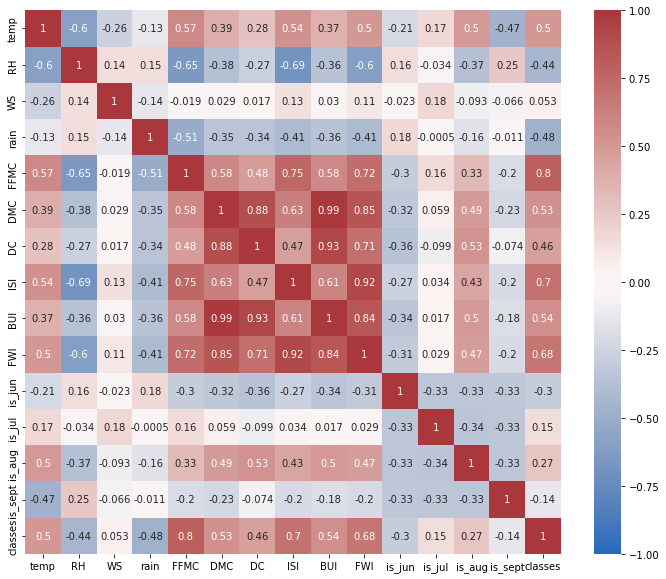

In [166]:
#Filters dataset to only Sidi Bel Abbes region and drops region column
sidi = fires[fires.region == 'Sidi-Bel Abbes']
sidi = sidi.drop(columns='region')

# Correlation Grid of variables
corr_grid = sidi.corr()

#Plots correlation in a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_grid, vmin=-1, vmax=1, center=0,  cmap='vlag', annot=True)
plt.show()

This dataset holds the same positives and negatives as the previous. High correlation with 'classes', however, high correlation with each other as well.

This time, the column with the with the strongest correlation to the target variable is 'FFMC. Therefore, all other input variables with a correlation of 0.65 to FFMC were excluded. Also, DMC and DC were removed due to their high correlation with a lot of variables.

In [167]:
sidi = sidi.drop(columns=['FWI', 'ISI', 'RH', 'DMC', 'DC'])

#### Method Testing

The same classification methods were tested, again using k fold cross validation due to the dataset only have 122 rows.

In [168]:
#Seperates input and outcome variables
#X is all variables except 'classes'
#y is only 'classes' column
X = sidi.iloc[:,:-1]
y = sidi.iloc[:,-1]

#Splits data into train and test sets at ratio of 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 6)

names2 = []
results2 = []
std2 = []

#Loops through each model in models list
for name, model in models:
    
    #Fits model with training data
    temp_model = model.fit(X_train, y_train)
    
    #Uses 10 folded validation to test model and record results
    kfold = KFold(n_splits = 10, random_state = 6, shuffle = True)
    cv_results = cross_val_score(temp_model, X_test, y_test, cv = kfold, scoring = 'accuracy')
    
    #Add name, mean score and std to relevent list for printing and plotting
    names2.append(name)
    results2.append(cv_results.mean())
    std2.append((cv_results.std())/2)
    
    print(f'{name}: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

LR: Accuracy of 75.0% (std: 0.2075)
SVC: Accuracy of 75.0% (std: 0.2075)
Trees: Accuracy of 100.0% (std: 0.0)
KNN: Accuracy of 70.0% (std: 0.1675)
Random forest: Accuracy of 100.0% (std: 0.0)


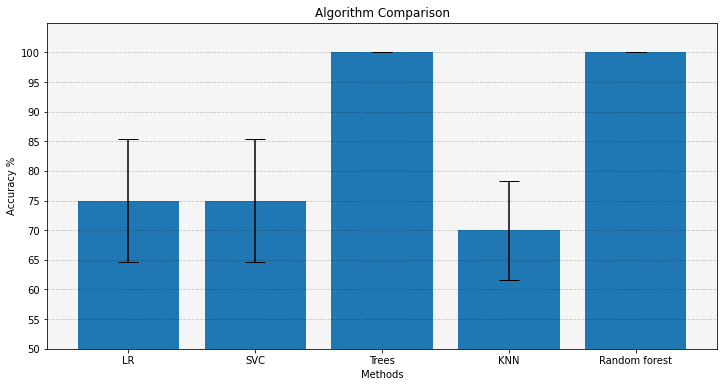

In [169]:
#Plots name vs mean score, with std as error bars
plt.figure(figsize = (12,6))
ax = plt.subplot()

plt.bar(names2, height=results2, yerr=std2, capsize=10)

plt.title('Algorithm Comparison')
plt.xlabel('Methods')
plt.ylabel('Accuracy %')

ax.set_xticks(range(5))
ax.set_xticklabels(names)
ax.set_ylim(0.5,1.05)
ax.set_yticks(np.arange(0.5,1.01,0.05))
ax.set_yticklabels(np.arange(50,101,5))
ax.grid(zorder=0, linestyle='dashed', axis='y', alpha=0.2, color='black')
ax.set_facecolor('whitesmoke')

plt.show()

For this dataset, only Decision Trees and Random Forest achieve an accuracy of 90%+ (100% for both). As a Random Forest method consists of many Decision Tree models, I decided to base my model around this method.

#### Feature Selection

The appropriate features were selected using the SelectFromModel function from the sklearn library. The threshold is set to 'mean' as default, so therefore, identifies features with an importance greater than the mean importance of all inputs.

In [170]:
#SelectFromModel applied to Random Forest model and fitted with training data
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

#Selected features then identified and printed using .get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(f"Important Features: {selected_feat[0]}, {selected_feat[1]}, {selected_feat[2]}")

Important Features: rain, FFMC, BUI


The feature selection method has identified **'rain'**, **'FFMC'** and **'BUI'** as the variables with the greatest importance to the model. Therefore, these will be used in the final model.

#### Hyperparameter Tuning

There are many hyperparameters for the RandomForest method. I decided to alter several of them and record the accuracy results to find the optimal parameters. These hyperparameters were:
* n_estimators
* criterion
* max_depth
* min_sample_leaf
* min_sample_split
* max_features

Due to the number of parameters being varied and the number of different possible combinations, RandomSearchCV was used in order to reduce computation time. The code which determines the best parameters and best score has been hashed out, but the results have been printed below.

In [171]:
#New input variable (sidi_X) defined after feature selection
sidi_X = sidi[['rain', 'FFMC', 'BUI']]
sidi_y = sidi['classes']

#New train-test split with new input variables
X_train, X_test, y_train, y_test = train_test_split(sidi_X, sidi_y, train_size = 0.8, random_state = 6)


rf = RandomForestClassifier()

# Set hyperparameter ranges
grid_params = dict()
grid_params['n_estimators'] = range(100,1000,200)
grid_params['criterion'] = ['gini', 'entropy']
grid_params['max_depth'] = range(2,20,1)
grid_params['min_samples_leaf'] = [1, 2, 4]
grid_params['min_samples_split'] = [2, 5, 10]
grid_params['max_features'] = ['auto', 'log2', 'sqrt']

# ## Creates RandomizedSearchCV which trains the model 'rf' with each possible combination of hyperparameters in 'grid_params'
# rand = RandomizedSearchCV(rf, grid_params, n_iter=10, cv=kfold)
# rand.fit(X_train, y_train)
# print(rand.best_params_)
# print(max(rand.cv_results_['mean_test_score']))

#Best Parameters and Mean Score Printed
print("Best Parameters:")
print("n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features='log2', max_depth=3, criterion='entropy'")
print('')
print(f"Best Mean Score: 0.9875")

Best Parameters:
n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features='log2', max_depth=3, criterion='entropy'

Best Mean Score: 0.9875


Using the optimal hyperparameters listed above, an extremely high score of 0.9875 was achieved. Therefore, these parameters will be used in the final model.

#### Final Model Validation

The model, after using the optimal conditions, is then fit with our training data and then used to predict the classification of our test data. The predictions are then compared to the actual classification to validate the effectiveness of our model.

The mean squared error of our training and testing data is observed to check for overfitting.

In [172]:
#Final rf model with optimal hyperparameters
modelS = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=2,
                                 max_features='log2', max_depth=3, criterion='entropy')

modelS.fit(X_train, y_train)

#Predict outcome classifications using train and test inputs and compare to actual outcomes to calculate MSE
#1. Training Error
pred_train = modelS.predict(X_train)
MSE_train = np.mean((pred_train - y_train)**2)
print("Training Error: ", MSE_train)

# 2. Testing Error
pred_test = modelS.predict(X_test)
MSE_test = np.mean((pred_test - y_test)**2)
print("Testing Error: ", MSE_test)

Training Error:  0.0
Testing Error:  0.04


The errors are even smaller than the previous model. Again, it can be determined that overfitting is not occuring.

Next we can view the confusion matrix and validate our model. During validation, a K fold cross validation method was apply again due to the dataset being relatively small.

In [173]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_test)
print('Confusion Matrix:')
print(confusion_matrix)
print('')

#Using 10 fold cross validation to score methods on all measurements in scoring list
scoring = ['accuracy', 'precision', 'recall', 'f1']
kfold = KFold(n_splits = 10, random_state = 6, shuffle = True)
results = cross_validate(estimator=modelS,
                               X=sidi_X,
                               y=sidi_y,
                               cv=kfold,
                               scoring=scoring,
                               return_train_score=True)

#Calls function defined earlier 
validator(results, tests)

Confusion Matrix:
[[10  1]
 [ 0 14]]

Mean train_accuracy: 99.91%
Mean test_accuracy: 98.33%

Mean train_precision: 100.0%
Mean test_precision: 100.0%

Mean train_recall: 99.86%
Mean test_recall: 97.46%

Mean train_f1: 99.93%
Mean test_f1: 98.64%



The Sidi Bel Abbes model scored extremely highly with almost perfect results:
* It has correctly predicted all but one of the outcomes.
* The one failed outcome was a False Positive result which, in the instance of this project, is better than a False Negative.
* It's test scores are almost as high as the training score, suggesting that, if new data was added to the model, it would be able to accurately predict the outcome.

## Bonus: Unsupervised Machine Learning Model

As a test, I attempted to fit a quick unsupervised machine learning model to the inital dataset which contains information from both regions.

In [174]:
total = fires.drop(columns='region')

This section uses a combination of Principal Component Analysis (PCA) and K-Means Clustering to train a model which can hopefully succesfully predict the fire outcome of all instances in the dataset. It uses the techniques of clustering to find patterns in the data, without using the classifier variable hence an unsupervised model.

Firstly, PCA was performed on the standardized data, in order to find the variance ratio of each component. The results were then plotted in a scree plot to determine the optimal number of components to use in the final model.

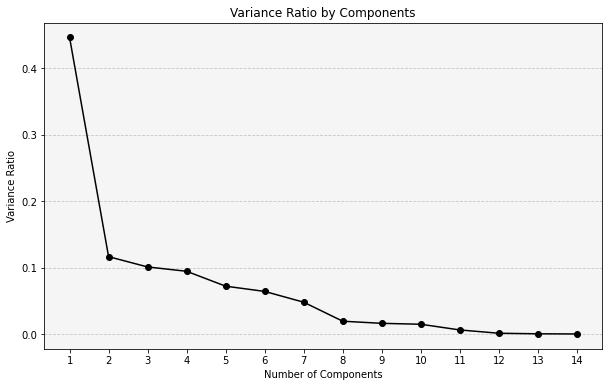

<Figure size 432x288 with 0 Axes>

In [175]:
stand_data = total.drop(columns=['classes'])

#Creates PCA model and fits with standardized data
pca = PCA()
pca.fit(stand_data)

#Variance Ratio of each component extracted
var = pca.explained_variance_ratio_

#Variance ratios plotted
plt.figure(figsize=(10,6))
ax=plt.subplot()

plt.plot(var, marker='o', color='black')

plt.title('Variance Ratio by Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')

ax.set_xticks(range(0,14,1))
ax.set_xticklabels(range(1,15,1))

ax.grid(zorder=0, linestyle='dashed', axis='y', alpha=0.2, color='black')
ax.set_facecolor('whitesmoke')

plt.show()
plt.clf()

Using the elbow method on the plot above, it can be deduced that 2 components should be used. Next, a new PCA model was created with the 'n_components = 2' parameter set and then fit and transformed using the standardized data.

The data was then projected onto the principal axes to observe the 2 clusters.

<Figure size 720x720 with 0 Axes>

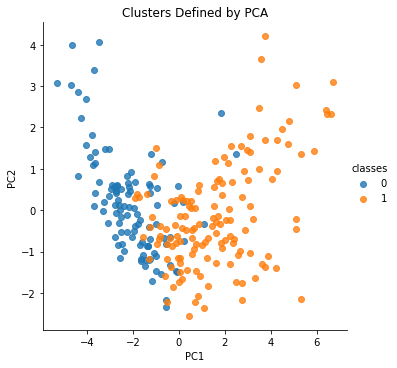

In [176]:
#New PCA model created with 2 components and fitted with same standardized data
pca2 = PCA(n_components=2)
pca2.fit(stand_data)
scores_pca = pca2.transform(stand_data)

#Dataframe created of principal components and class
scores_pca = pd.DataFrame(scores_pca)
scores_pca.columns = ['PC1', 'PC2']
scores_pca['classes'] = total.classes

#Principal component values plotted on axes with 'classes' as the hue parameter
plt.figure(figsize=(10,10))
sns.lmplot(x='PC1', y='PC2', data=scores_pca, hue='classes', fit_reg=False)
plt.title('Clusters Defined by PCA')
plt.show()

As shown above, the 2 clusters are quite distinct, however there is some overlapping and a few anomalies. The accuracy scores of the model may be hindered by this.

Next, a K-Means Clustering instance was then initialized using 'n_clusters=2', as we know there are only 2 values for the outcome variable ('not fire' and 'fire'). This model was then fit with the results from the PCA method to create an unsupervised ML model. It's predictions for the outcomes were extracted.

These predictions were compared to the real outcomes to validate the model.

In [177]:
#K-Means Clustering model created with 2 clusters and fitted with PCA scores
kmeans_pca = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

#Predicted labels extracted
kmeans_labels = kmeans_pca.labels_

#Actual labels saved to 'labels'
labels = total.classes.to_numpy()

# Predicted and actual labels compared in confusion matrix and test scores
confusion_matrix = metrics.confusion_matrix(labels, kmeans_labels)
print('Confusion Matrix:')
print(confusion_matrix)
print('')
print(f'Accuracy Score: {round(metrics.accuracy_score(labels, kmeans_labels),3)}')
print(f'Precision Score: {round(metrics.precision_score(labels, kmeans_labels),3)}')
print(f'Recall Score: {round(metrics.recall_score(labels, kmeans_labels),3)}')
print(f'F1 Score: {round(metrics.f1_score(labels, kmeans_labels),3)}')

Confusion Matrix:
[[103   3]
 [ 45  93]]

Accuracy Score: 0.803
Precision Score: 0.969
Recall Score: 0.674
F1 Score: 0.795


The model performed averagely and although it achieved an accuracy score of 80.3%, there were too many False Negative results to deem the model a success. This is highlighted by the poor recall score of 67.4%.

Despite the decent accuracy score, this model is not effective enough yet to be used in real world applications.